In [ ]:
from model.models import XceptionClassifier, DenseNetClassifier, InceptionV3Classifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from utils.datasets import BioClassify
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import argparse
import torch
import os

In [ ]:
# Import Self Defined Modules
models = [DenseNetClassifier(num_classes=2), InceptionV3Classifier(num_classes=2), XceptionClassifier(num_classes=2)]
model_names = ['DenseNetClassifier', 'InceptionV3Classifier', 'XceptionClassifier']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

checkpoint_path = './checkpoints/'
target_stain = './data/target.png'

In [ ]:
checkpoints = np.array(os.listdir('checkpoints'))
# checkpoints = np.array([checkpoint for checkpoint in checkpoints if 'best' in checkpoint])
checkpoints_densenet = np.array([checkpoint for checkpoint in checkpoints if 'densenet' in checkpoint])
checkpoints_inception = np.array([checkpoint for checkpoint in checkpoints if 'inception' in checkpoint])
checkpoints_xception = np.array([checkpoint for checkpoint in checkpoints if 'xception' in checkpoint])
checkpoints = np.array([checkpoints_densenet, checkpoints_inception, checkpoints_xception])

In [ ]:
def inference(dataloader, model):
    probs = []
    labels = []
    for data, label in tqdm(dataloader):
        data = Variable(data.permute(0, 3, 1, 2).cuda())
        output = model(data)
        probs.extend(torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy())
        labels.extend(label.numpy())
    return probs, labels

In [ ]:
test_data_path = '/home/KutumLabGPU/code4oralcancer/Soumyajit/OC-Binary-Classifier/data/test/'
test_data_files = np.array(os.listdir(test_data_path))
val_data_path = '/home/KutumLabGPU/code4oralcancer/Soumyajit/OC-Binary-Classifier/data/val/'
val_data_files = np.array(os.listdir(val_data_path))
test_data_files, val_data_files

normal_osmf_test = test_data_path + 'normal-osmf-test.csv'
normal_oscc_test = test_data_path + 'normal-oscc-test.csv'
osmf_oscc_test = test_data_path + 'osmf-oscc-test.csv'

normal_osmf_val = val_data_path + 'normal-osmf-val.csv'
normal_oscc_val = val_data_path + 'normal-oscc-val.csv'
osmf_oscc_val = val_data_path + 'osmf-oscc-val.csv'

In [ ]:
def load_model(model_idx, checkpoint_idx):
    # Model
    model = models[model_idx]
    print(checkpoints[model_idx][checkpoint_idx])
    checkpoint = torch.load(checkpoint_path+checkpoints[model_idx][checkpoint_idx])
    model.load_state_dict(checkpoint)
    model = torch.compile(model)
    model.cuda()
    model.eval()   
    return model

In [18]:
checkpoints_densenet

array(['20240324-202927_densenet_normal_osmf_1_model.pth',
       '20240325-014642_densenet_normal_oscc_2_model.pth',
       '20240324-203049_densenet_normal_oscc_1_model.pth',
       '20240325-115011_densenet_osmf_oscc_3_model_best.pth',
       '20240325-080013_densenet_normal_osmf_3_model_best.pth',
       '20240325-020227_densenet_normal_osmf_2_model_best.pth',
       '20240325-115011_densenet_osmf_oscc_3_model.pth',
       '20240324-203013_densenet_osmf_oscc_1_model_best.pth',
       '20240324-202927_densenet_normal_osmf_1_model_best.pth',
       '20240324-203013_densenet_osmf_oscc_1_model.pth',
       '20240325-040434_densenet_osmf_oscc_2_model_best.pth',
       '20240325-070931_densenet_normal_oscc_3_model.pth',
       '20240324-203049_densenet_normal_oscc_1_model_best.pth',
       '20240325-040434_densenet_osmf_oscc_2_model.pth',
       '20240325-014642_densenet_normal_oscc_2_model_best.pth',
       '20240325-080013_densenet_normal_osmf_3_model.pth',
       '20240325-070931_dens

In [69]:
model_idx = 0
check_idx = 6
fold_no = 3

data_path = osmf_oscc_test
model = load_model(model_idx, check_idx)

dataset = BioClassify(paths={"data": data_path, "target_stain": target_stain})
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=1)
probs, labels = inference(dataloader, model)

df_res = pd.DataFrame({'probs': probs, 'labels': labels})

20240325-115011_densenet_osmf_oscc_3_model.pth


  0%|          | 0/813 [00:00<?, ?it/s]

100%|██████████| 813/813 [02:20<00:00,  5.77it/s]


In [70]:
# Compute confusion matrix
cm = confusion_matrix(labels, np.round(probs))
class_names = ['OSMF', 'OSCC']
class_folder = class_names[0]+'-'+class_names[1]
type_1 = 'Test'
type_2 = 'Last-Epoch'
mode = 'external/last'
results = 'results-dense'

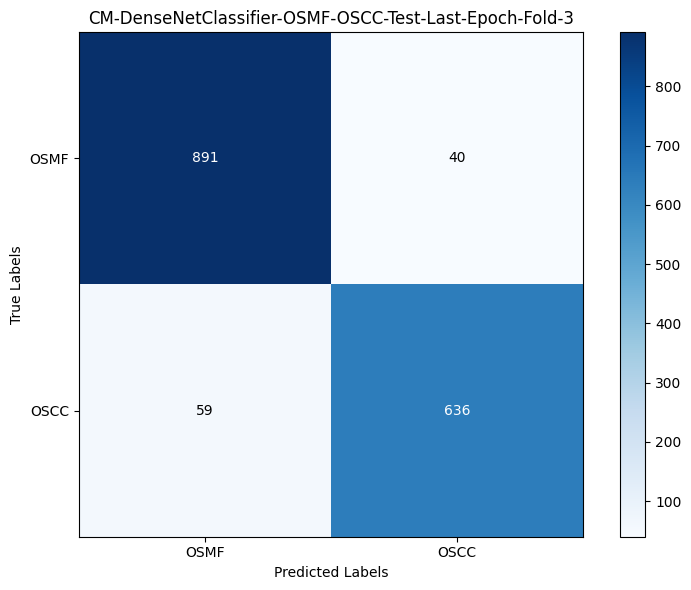

In [71]:
subtitle = f"{class_names[0]}-{class_names[1]}-{type_1}-{type_2}-Fold-{fold_no}"
plt_title = f"CM-{model_names[model_idx]}-{subtitle}"
res_title = f"RES-{model_names[model_idx]}-{subtitle}"
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(plt_title)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
# Add labels to each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()

os.makedirs(f'{results}/{mode}/{class_folder}', exist_ok=True)

plt.savefig(f'{results}/{mode}/{class_folder}/{plt_title}')
cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
cm_df.to_csv(f'{results}/{mode}/{class_folder}/{plt_title}.csv')
df_res.to_csv(f'{results}/{mode}/{class_folder}/{res_title}.csv', index=False)

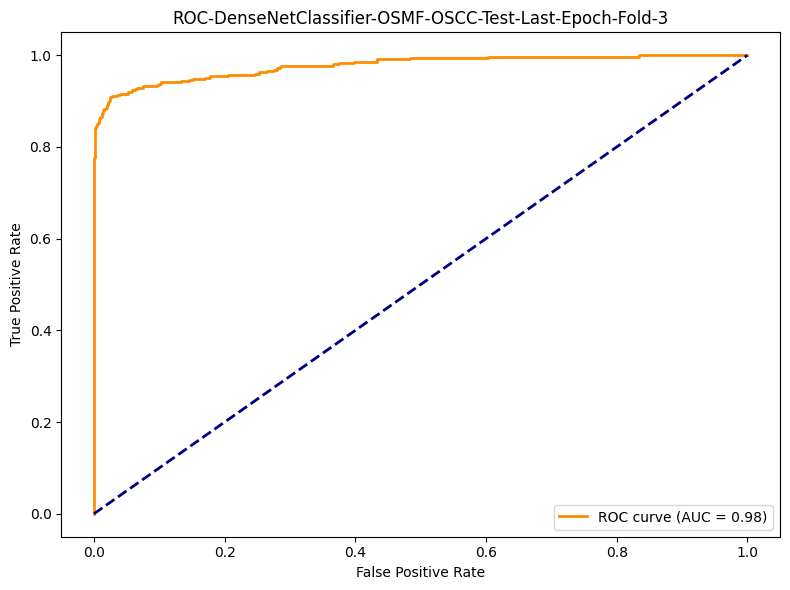

In [72]:
subtitle = f"{class_names[0]}-{class_names[1]}-{type_1}-{type_2}-Fold-{fold_no}"
plt_title = f"ROC-{model_names[model_idx]}-{subtitle}"
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(plt_title)
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f'{results}/{mode}/{class_folder}/{plt_title}')
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_df.to_csv(f'{results}/{mode}/{class_folder}/{plt_title}.csv', index=False)